# Introduction

## Context

Sendy, in partnership with insight2impact facility, is hosting a Zindi challenge to predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination.

The solution will help Sendy enhance customer communication and improve the reliability of its service; which will ultimately improve customer experience. In addition, the solution will enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved resource management and planning for order scheduling.

Sendy helps men and women behind every type of business to trade easily, deliver more competitively, and build extraordinary businesses.

## Problem Statement

Data is a critical component in helping Sendy to build more efficient, affordable and accessible solutions. Given the details of a Sendy order, can we use historic data to predict an accurate time for the arrival of the rider at the destination of a package? In this competition, we’re challenging you to build a model that predicts an accurate delivery time, from picking up a package to arriving at the final destination. An accurate arrival time prediction will help all businesses to improve their logistics and communicate an accurate time to their customers.

# Data Exploration

###### Import packages and load data files

In [45]:
# import packages
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline

import pprint
pp = pprint.PrettyPrinter()

In [46]:
# load data
train_data = pd.read_csv(r'C:\Users\tbndo\Google Drive\Projects\regression-predict-api-template\predict deliverable\data\Train.csv')
test_data = pd.read_csv(r'C:\Users\tbndo\Google Drive\Projects\regression-predict-api-template\predict deliverable\data\Test.csv')
riders_data = pd.read_csv(r'C:\Users\tbndo\Google Drive\Projects\regression-predict-api-template\predict deliverable\data\Riders.csv')

###### display variable descriptions

Variable descriptions are stored in the csv Variable definations. Here we load that csv and print out each row.

In [47]:

variable_defs = pd.read_csv(r'C:\Users\tbndo\Google Drive\Projects\regression-predict-api-template\predict deliverable\data\VariableDefinitions.csv')
variable_defs = variable_defs.drop_duplicates(subset = 'Order No').dropna(how = 'all')
variable_defs.set_index('Order No', inplace = True)
for feature in variable_defs.index:
    print('{}: '.format(feature), variable_defs.loc[feature, :][0])

User Id:  Unique number identifying the customer on a platform
Vehicle Type:  For this competition limited to bikes, however in practice Sendy service extends to trucks and vans
Platform Type:  Platform used to place the order, there are 4 types
Personal or Business:  Customer type
Placement - Day of Month:  Placement - Day of Month i.e 1-31
Placement - Weekday (Mo = 1):  Placement - Weekday (Monday = 1)
Placement - Time:  Placement - Time - Time of day the order was placed
Confirmation - Day of Month:  Confirmation - Day of Month i.e 1-31
Confirmation - Weekday (Mo = 1):  Confirmation - Weekday (Monday = 1)
Confirmation - Time:  Confirmation - Time - Time of day the order was confirmed by a rider
Arrival at Pickup - Day of Month:  Arrival at Pickup - Day of Month i.e 1-31
Arrival at Pickup - Weekday (Mo = 1):  Arrival at Pickup - Weekday (Monday = 1)
Arrival at Pickup - Time:  Time of day the the rider arrived at the location to pick up the order - as marked by the rider through the S

###### Display the shape of train and test data
Train consists of 21201 orders and 29 features. Test_data consists of orders and 25 features. This makes sense as the train data should contain extra columns that are not available in the test data i.e the target. Lets do further investigation of this.

In [48]:
print('Train rows and columns :', train_data.shape)
print('Test rows and columns :', test_data.shape)

Train rows and columns : (21201, 29)
Test rows and columns : (7068, 25)


###### Investigating the target. 
We find that really train_data has 4 extra columns that relate to the target. These are displayed in the output below and stored in a set object named target_vars

In [49]:
train_column_names = train_data.columns.values # get the train column names 
test_column_names = test_data.columns.values # het the test column names
target_vars = set(train_column_names) - set(test_column_names) # the difference between train and test column names leaves the trget column names 
print('Target columns')
print(target_vars)

Target columns
{'Arrival at Destination - Time', 'Arrival at Destination - Weekday (Mo = 1)', 'Time from Pickup to Arrival', 'Arrival at Destination - Day of Month'}


We are also provided with a Riders csv file. Given that a single rider can make multiple deliveries we do not expect the length of this file to be the same as that of our training or testing datasets. Below we display the total number of riders (960). Of these 960, 924 have appearance in train_data while 822 make appearance in test_data. 952 make apperance in both train and test data, meaning 8 riders are not are not have not made any deliveries in the provided datasets.

In [50]:
print(' Total Riders :', riders_data['Rider Id'].nunique(), 
      '\n Riders in train data :',train_data['Rider Id'].nunique(),
      '\n Riders in test data :',test_data['Rider Id'].nunique(),
      '\n Intersection between train & test data :', pd.Series(test_data['Rider Id'].to_list() + train_data['Rider Id'].to_list()).nunique()
     )

 Total Riders : 960 
 Riders in train data : 924 
 Riders in test data : 822 
 Intersection between train & test data : 952


###### task: Join the riders_data with both train and test data. 
Prioritise observation in train and test data. See the how parameter of pd.merge in the cell below.

In [51]:
train_data = pd.merge(
                left = train_data,
                right = riders_data,
                how = 'left'
            )

test_data = pd.merge(
                left = test_data,
                right = riders_data,
                how = 'left'
            )

In [52]:
# print train_data
train_data.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,1023,242,12.5,114
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341,886,283,14.5,113
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214,2311,872,14.1,533


In [53]:
# print test_data
test_data.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,439,1511,13.3,171
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,...,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868,488,273,14.4,45
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,...,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26,833,460,13.1,67
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,...,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685,487,560,13.7,44
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,...,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858,4761,1120,14.1,1010


###### Conclude
Note that the number of columns has increased by 4 in both train and test datasets. These are the 4 features that come with the riders_data i.e 
1. No_Of_Orders:   Number of Orders the rider has delivered
2. Age:  Number of days since the rider delivered the first order
3. Average_Rating:  Average rating of the rider
4. No_of_Ratings

We are now a little familiar with the data. Lets get more familiar with it by exploring the data structures associated with all our feature columns.

## Data Structures

###### Check and Classify Columns by type
The importance of correctly encoding column datatypes cannot be overstated. This will become clear later when we do Exploratory Data Analysis and eventually when preprocessing data for machine learning. Numeric features should encoded as such and so are categorical features and date and time objects. This section is devoted to making ensure consistency in data types. We begin by checking the current datatype per column. If the datatypes are correct, we need to classify the column names either to numeric_vars for numeric columns or factor_vars for categorical columns.

In [54]:
# user function to check a pd.Serie()'s datatype
def checkDataType(df, column_name):
    dtype = df[column_name].dtype
    return str(dtype)

# user function that classifies columns by datatype
def classifyColumnsByDataType(df):

    id_cols = ['Order No', 'User Id', 'Rider Id'] # not interested in classifying id columns
    
    numeric_type = ['int16', 'int64', 'float16', 'float64'] # these are classified as numeric varibles
    factor_type = ['object']                                # these are classified as categorical / factor type
    
    numeric_vars = list()                                   # empty container
    factor_vars = list()                                    # empty container

    for column_name in df.columns:
        data_type = checkDataType(df = df, column_name = column_name) # check data type

        if column_name not in id_cols + list(target_vars):            # classify accordingly
            if data_type in numeric_type:
                numeric_vars.append(column_name)
            else:
                factor_vars.append(column_name)
#             print('{}: '.format(column_name), checkDataType(df = train_data, column=column_name))
    return numeric_vars, factor_vars                      # return tuple of 2 (numeric and factors)

In [55]:
numeric_vars, factor_vars = classifyColumnsByDataType(df = train_data) # apply function

print('Numeric Features:')
pp.pprint(numeric_vars)
print('')
print('Categorical/Factor Features:')
pp.pprint(factor_vars)

Numeric Features:
['Platform Type',
 'Placement - Day of Month',
 'Placement - Weekday (Mo = 1)',
 'Confirmation - Day of Month',
 'Confirmation - Weekday (Mo = 1)',
 'Arrival at Pickup - Day of Month',
 'Arrival at Pickup - Weekday (Mo = 1)',
 'Pickup - Day of Month',
 'Pickup - Weekday (Mo = 1)',
 'Distance (KM)',
 'Temperature',
 'Precipitation in millimeters',
 'Pickup Lat',
 'Pickup Long',
 'Destination Lat',
 'Destination Long',
 'No_Of_Orders',
 'Age',
 'Average_Rating',
 'No_of_Ratings']

Categorical/Factor Features:
['Vehicle Type',
 'Personal or Business',
 'Placement - Time',
 'Confirmation - Time',
 'Arrival at Pickup - Time',
 'Pickup - Time']


###### Motivation for classifying columns by type
The importance of creating vector objects that contain a group of column names belonging in each class will become apparent when we start analysing our data. For example, it will be easy to just apply a certain transformation to factor features by simply filtering our data. See following example. 

In [56]:
train_data.loc[:, factor_vars].head()

,Vehicle Type,Personal or Business,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time
0,Bike,Business,9:35:46 AM,9:40:10 AM,10:04:47 AM,10:27:30 AM
1,Bike,Personal,11:16:16 AM,11:23:21 AM,11:40:22 AM,11:44:09 AM
2,Bike,Business,12:39:25 PM,12:42:44 PM,12:49:34 PM,12:53:03 PM
3,Bike,Business,9:25:34 AM,9:26:05 AM,9:37:56 AM,9:43:06 AM
4,Bike,Personal,9:55:18 AM,9:56:18 AM,10:03:53 AM,10:05:23 AM


Filtering train_data and displaying only the factor_vars, it is clear that ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time'] are not supposed to be encoded as factors. They should be encoded as time objects. Now we can apply a function to encode them as such. Looking at the output above, see the pattern. All features we want to transform have "Time" in their column name. Use string.find() method to identify them and apply the transformation. Also note that these columns are removed from factor_vars and appended to time_vars who serves exactly the same purpose as numeric_vars and factor_vars. See helper function below.

In [57]:
# user function to encode factors as time objects
time_vars = list()
def convertToTime(df):
   
    for column_name in df.loc[:, factor_vars].columns.to_list():

        if column_name.find("Time") != -1:     # find columns with string "Time"

            print('{} :'.format(column_name), 'Found') # print () if found
            time_vars.append(column_name)              # append to time_vars object 
            factor_vars.remove(column_name)            # remove from factor_vars
            
            df['{}'.format(column_name)] = df.loc[:, column_name].map(lambda timestring: pd.to_datetime(timestring).time())
            
    return df

In [58]:
# apply function and print results
convertToTime(df = train_data)
print(time_vars)
train_data.loc[:, time_vars].head()

Placement - Time : Found
Confirmation - Time : Found
Arrival at Pickup - Time : Found
Pickup - Time : Found
['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time']


,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time
0,09:35:46,09:40:10,10:04:47,10:27:30
1,11:16:16,11:23:21,11:40:22,11:44:09
2,12:39:25,12:42:44,12:49:34,12:53:03
3,09:25:34,09:26:05,09:37:56,09:43:06
4,09:55:18,09:56:18,10:03:53,10:05:23


In [59]:
unique_values = train_data.loc[:, numeric_vars].nunique()
mask = unique_values < 40
more_factors = unique_values[mask].index.to_list()
numeric_vars = list(set(numeric_vars) - set(more_factors))
factor_vars = factor_vars + more_factors

In [60]:
train_data.loc[:, factor_vars].head()

,Vehicle Type,Personal or Business,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1)
0,Bike,Business,3,9,5,9,5,9,5,9,5
1,Bike,Personal,3,12,5,12,5,12,5,12,5
2,Bike,Business,3,30,2,30,2,30,2,30,2
3,Bike,Business,3,15,5,15,5,15,5,15,5
4,Bike,Personal,1,13,1,13,1,13,1,13,1


In [61]:
train_data.loc[:, numeric_vars].head()

,Distance (KM),Pickup Long,Pickup Lat,No_of_Ratings,Age,Temperature,Destination Long,No_Of_Orders,Destination Lat,Precipitation in millimeters,Average_Rating
0,4,36.830370,-1.317755,549,1309,20.4,36.829741,1637,-1.300406,NaN,13.8
1,16,36.899315,-1.351453,69,339,26.4,36.814358,396,-1.295004,NaN,13.6
2,3,36.843419,-1.308284,114,242,NaN,36.828195,1023,-1.300921,NaN,12.5
3,9,36.832396,-1.281301,113,283,19.2,36.795063,886,-1.257147,NaN,14.5
4,9,36.792118,-1.266597,533,872,15.4,36.809817,2311,-1.295041,NaN,14.1


In [62]:
train_data.loc[:, target_vars].head()

,Arrival at Destination - Time,Arrival at Destination - Weekday (Mo = 1),Time from Pickup to Arrival,Arrival at Destination - Day of Month
0,10:39:55 AM,5,745,9
1,12:17:22 PM,5,1993,12
2,1:00:38 PM,2,455,30
3,10:05:27 AM,5,1341,15
4,10:25:37 AM,1,1214,13


###### Conclude
This has been a really insightful section. We have leant about our data structures and managed to get organised in hopes of making the data science process efficient in later chapters. However, looking at the table of numeric features above we see missing values for the column "Precipitation in millimetres". Is it possible that it is not the only column with such behaviour. The next section will be devoted to that. Let's proceed. 

## Missing Values

###### Investigate missing values and treat them accordingly
Missing values are a common problem in datasets and for a number of different reasons. In this part of the notebook we will do a minimal assessment of missing values. It is important however that we understand missingness from both the perspective of the train_data and test_data. As such we want to see what columns have missing data in both the train and test dataset ans well as the proportion of missingness in each of those columns. The cell below does just that and displays a table as output. See below.

In [63]:
train_data.name = 'train_data'
test_data.name = 'test_data'

def findMissing(df):
    
    missing = df.isnull().sum()
    mask = missing > 0
    perc_missing = missing[mask].div(len(df)).mul(100).round(1)
    perc_missing = pd.DataFrame({'Percentage': perc_missing})
    perc_missing['data'] = df.name
    return perc_missing

perc_missing = pd.concat(
    [findMissing(train_data), findMissing(test_data)]
)
perc_missing

,Percentage,data
Temperature,20.6,train_data
Precipitation in millimeters,97.4,train_data
Temperature,20.3,test_data
Precipitation in millimeters,97.2,test_data


Looks like only 2 columns have missing data (Temperature and Precipitation in millimeters) in both train and test data and the distribution of missingness seems to be consistent in both datasets. This is fortunate for us as we wouldn't want a situation where for instance Temperature has low missingness in the train data of say 20% and high missingness of say 80% in the test data. The values indicate an almost identical distribution of missing values from the train to the test data. GOOD!. However, the missingness is high, particularly for the Precipitation variable (97.2%). We may have to exclude this feature from modelling. Temerature also has high missingness, about 20%. A later section under Exploratory Data Analysis will go into detail on how we treat these missing values. In the meantime we create yet another container object that stored a vector of these 2 columns (missing_vars), serves the same purpose as numeric_vars, factor_vars etc.

In [64]:
missings_vars = perc_missing.index.unique().to_list()
train_data.loc[:,missings_vars].head()

,Temperature,Precipitation in millimeters
0,20.4,NaN
1,26.4,NaN
2,NaN,NaN
3,19.2,NaN
4,15.4,NaN


###### Conclude
By now, we should be so much more familiar with the data. GOOD! Let's go a little further. Let's look at the distribution of each of our features

# Exploratory Data Analysis - 1

## Univariate Analysis

###### task: plot histograms for numeric features
What better way to learn more about a dataset than by actually viualising it. Here we visualise numeric features. We lookout for the following:
1. outliers - these are values that lie too far are away from the rest of the other values in the vector of the target (the variable we attempt to predict)
2. leverage points - same as outliers except that this time we refer to predictor features.

The motivation for investigating and treating these values is as follows: outlier values and/or leverage points in data distributions sometimes have an impact in the pattern that is learnt by the models we build later. The term high leverage refers to the tendency of such values to affect the fit of the line, particularly in parameterised models like linear regression. As such, treating them accordingly allows such models to learn the underlying trend/distribution of the data, rather than one time instances that may never again occur in the data and at times these values are the result of data collection errors. The code cel below displays histograms for all numeric features.

In [65]:
train_data.loc[:, ['Order No'] + numeric_vars ].head()

,Order No,Distance (KM),Pickup Long,Pickup Lat,No_of_Ratings,Age,Temperature,Destination Long,No_Of_Orders,Destination Lat,Precipitation in millimeters,Average_Rating
0,Order_No_4211,4,36.830370,-1.317755,549,1309,20.4,36.829741,1637,-1.300406,NaN,13.8
1,Order_No_25375,16,36.899315,-1.351453,69,339,26.4,36.814358,396,-1.295004,NaN,13.6
2,Order_No_1899,3,36.843419,-1.308284,114,242,NaN,36.828195,1023,-1.300921,NaN,12.5
3,Order_No_9336,9,36.832396,-1.281301,113,283,19.2,36.795063,886,-1.257147,NaN,14.5
4,Order_No_27883,9,36.792118,-1.266597,533,872,15.4,36.809817,2311,-1.295041,NaN,14.1


In [66]:
# plot barchars for categorical features - Lookout for too many levels that can be grouped together
def generateMultiDist(df, variables, nrows, ncols, length, width):

    rows = range(0, nrows)
    columns = range(0, ncols)
    axis_position = list()

    for i,j in enumerate(rows):
        axis_position.append((i, j))

    for x in itertools.permutations(rows, len(columns)):
        axis_position.append(x[0:2])
    axis_position = pd.Series(axis_position).drop_duplicates().sort_values().to_list()

    var_axes = {variable: list(ax) for variable, ax in zip(variables, axis_position)}

    fig, axes = plt.subplots(nrows, ncols, figsize = (width, length))
    for variable, ax in var_axes.items():

        x = ax[1]
        y = ax[0]

        multiDist = sns.distplot(
                        df[variable], 
                        color = "teal", 
                        ax = axes[x, y]
                    )
    return multiDist

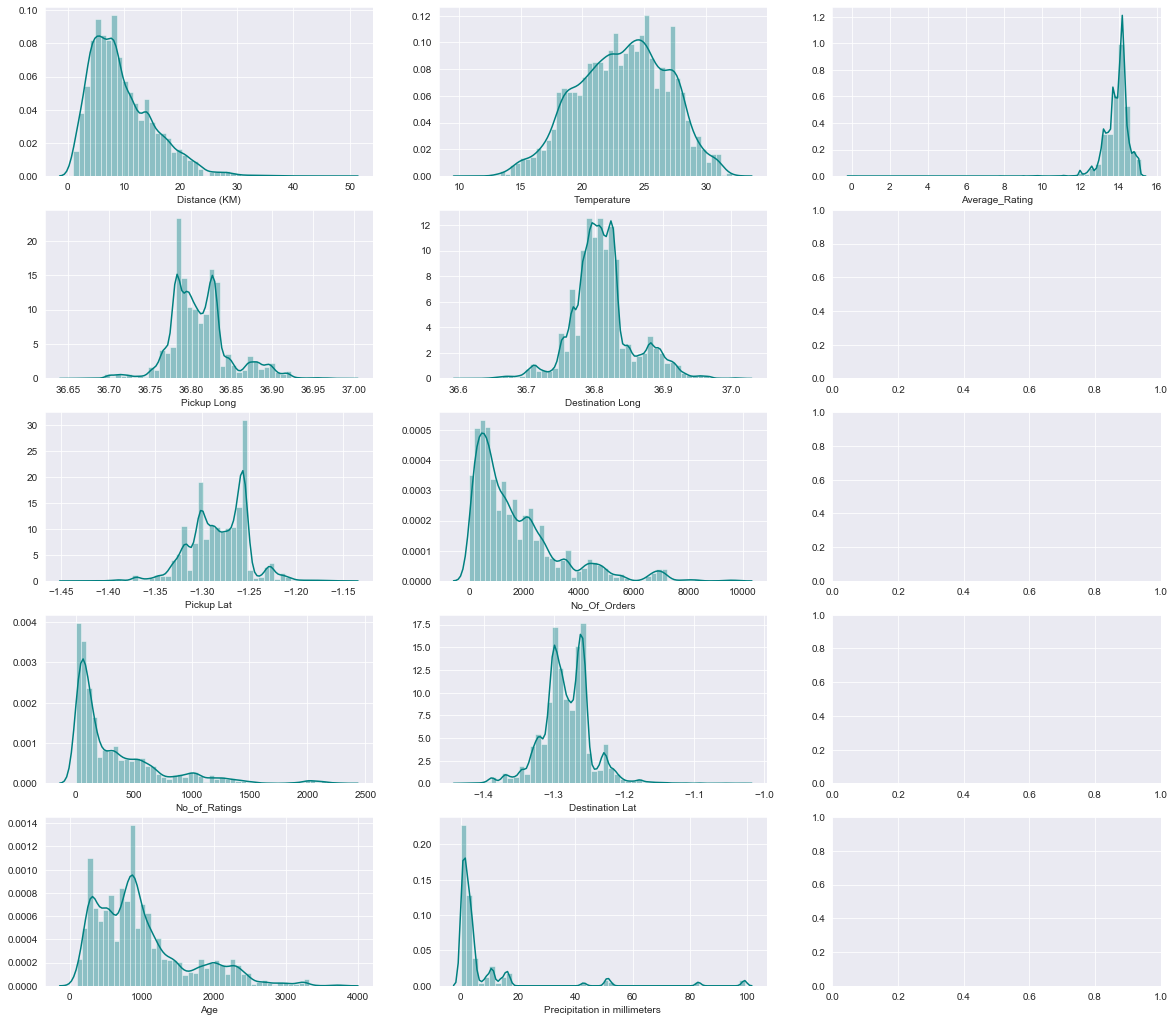

In [74]:
generateMultiDist(
    df = train_data,
    variables = numeric_vars,
    nrows = 5,
    ncols = 3,
    length = 18,
    width = 20
)

In [143]:
# Further analysis of missing values (if required)

# Benchmark Model

In [ ]:
# minimal data preprocessing (just enough to build base model)

In [ ]:
# fit model and cross validate perfomance

# Exploratory Data Analysis - 2

## Multivariate Analysis

In [7]:
# analyse relationships between features (correlation and factor analysis)

In [8]:
# check for collinearity and multi-collinearity

In [ ]:
# analyses relationship between features and target

# Feature Engineering

In [ ]:
# investigate non linearity

In [ ]:
# investigate feature interactions and synergy

In [ ]:
# other transformations (data mining)

# Feature Selection

In [ ]:
# L1 and L2 Regularisation

In [9]:
# forward selection, backward selection and/or mixed selection

In [10]:
# genetic algorithms (borita)

In [ ]:
# Random forests and feature importance

# Model Selection 

In [ ]:
# fit multiple models and do hyper-parameter tuning

In [ ]:
# cross validate model perfomance

In [ ]:
# select the best model and implement it as final solution

# Summary of Conclusions

In [ ]:
# summarise findings and make recommendations